In [1]:
import awkward as ak
import sys
sys.path.append("/n/home12/jlazar/GNN_WITH_LEANDER/plotting")
from event_plotting import plot_event
from scipy.optimize import differential_evolution

In [2]:
class Module(object):
    """
    Detection module.
    Attributes:
        pos: np.ndarray
            Module position (x, y, z)
        noise_rate: float
            Noise rate in 1/ns
        efficiency: float
            Module efficiency (0, 1]
        self.key: collection
            Module identifier
    """

    def __init__(self, pos, key, noise_rate=1, efficiency=0.2, serial_no=None):
        """Initialize a module."""
        self.pos = pos
        self.noise_rate = noise_rate
        self.efficiency = efficiency
        self.key = key
        self.serial_no = serial_no

    def __repr__(self):
        """Return string representation."""
        return repr(
            f"Module {self.key}, {self.pos} [m], {self.noise_rate} [Hz], {self.efficiency}"
        )

class Detector(object):
    """ Interface for detector methods
    """
    def __init__(self, modules):
        """Initialize detector."""
        #self.modules = modules
        #self.module_coords = np.vstack([m.pos for m in self.modules])
        # We need to move all our modules to a coordinate system
        # Where (0,0,0) is the center of the detector
        self._offset = np.mean(np.array([m.pos for m in modules]), axis=0)
        self.modules = [Module(m.pos-self._offset, m.key,
            noise_rate=m.noise_rate, efficiency=m.efficiency, serial_no=m.serial_no)
        for m in modules]
        self.module_coords = np.vstack([m.pos for m in self.modules])
        self.module_coords_ak = ak.Array(self.module_coords)
        self.module_efficiencies = np.asarray([m.efficiency for m in self.modules])
        self.module_noise_rates = np.asarray([m.noise_rate for m in self.modules])

        # TODO replace this with the functions David writes
        self._outer_radius = np.linalg.norm(self.module_coords, axis=1).max()
        self._outer_cylinder = (
            np.linalg.norm(self.module_coords[:, :2], axis=1).max(),
            2 * np.abs(self.module_coords[:, 2].max()),
        )
        self._n_modules = len(modules)
        self._om_keys = [om.key for om in self.modules]

    def __getitem__(self, key):
        idx = self._om_keys.index(key)
        return self.modules[idx]

    def __add__(self, other):
        modules = np.hcat(self.modules, other.modules)
        return Detector(modules)

    def subdetectors(self, nmodules):
        start = 0
        end = nmodules
        slc = slice(start, end)
        subdetectors = [Detector(self.modules[slc])]
        while end <= len(self.modules):
            start += nmodules
            end += nmodules
            slc = slice(start, end)
            subdet = Detector(self.modules[slc])
            subdetectors.append(subdet)
        return subdetectors

    @property
    def n_modules(self):
        return self._n_modules

    @property
    def outer_radius(self):
        return self._outer_radius

    @property
    def outer_cylinder(self):
        return self._outer_cylinder
    
    @property
    def offset(self):
        return self._offset

    def to_f2k(
            self,
            geo_file,
            serial_nos=[], mac_ids=[]) -> None:
        """
        Write detector corrdinates into f2k format.
        Parameters
            d: Detector
                Detector object to write out
            serial_nos: list{str}
                serial numbers for the optical modules
            mac_ids: list{str}
                MAC (I don't think this is actually
                what this is called) IDs for the DOMs
        """
        # Make sure serial numbers are compatible with the list of OMs
        if serial_nos:
            if len(serial_nos)!=len(self.modules):
                raise ValueError("serial numbers incompatible with modules")
        # Make up random place holders
        else:
            import string, random
            serial_nos = ["0x"+"".join(random.choices(
                '0123456789abcdef', k=12
            ))
                    for _ in range(len(self.modules))
                    ]
        # Make sure serial numbers are compatible with the list of OMs
        if mac_ids:
            if len(mac_ids)!=len(self.modules):
                raise ValueError("mac id list incompatible with modules")
        # Make up random place holders
        else:
            import string, random
            mac_ids = [''.join(random.choices(
                string.ascii_uppercase + string.digits, k=8))
                    for _ in range(len(self.modules))
                    ]
            keys = [m.key for m in self.modules]
        with open(geo_file, "w") as f2k_out:
            for mac_id, serial_no, pos, key in zip(
                mac_ids, serial_nos, self.module_coords+self._offset, keys
            ):
                line = f"{mac_id}\t{serial_no}\t{pos[0]}\t{pos[1]}\t{pos[2]}"
                if hasattr(key, "__iter__"):
                    for x in key:
                        line += f"\t{x}"
                else:
                    line += f"\t{key}"
                line += "\n"
                f2k_out.write(line)
def detector_from_geo(
    fname,
    efficiency=0.2,
    noise_rate=1
) -> Detector:
    """
    Create a Detector object from a geometry file
    Parameters
    __________
        fname: str
            geo-file where detector information is stored
        noise_rate: float
            Noise rate in 1/ns
        efficiency: float
            Module efficiency (0, 1]
    Returns
    _______
        det: Detector
    """
    pos = []; keys = []
    with open(fname) as geo_in:
        read_lines = geo_in.readlines()
        modules_i = read_lines.index("### Modules ###\n")

        for line in read_lines[modules_i+1:]:
            line = line.strip("\n").split("\t")
            pos.append(
                np.array([float(line[0]), float(line[1]),
                float(line[2])]))
            pos_out = np.array(pos)
            keys.append((int(line[3]),int(line[4])))

    import string, random
    # random.seed(config["general"]["random state seed"])

    sers = ["0x"+"".join(random.choices(
        '0123456789abcdef', k=12
    ))
        for _ in range(len(pos))
    ]
    from itertools import repeat
    efficiency = repeat(efficiency)
    noise_rate = repeat(noise_rate)
    # efficiency, noise_rate = iter_or_rep(efficiency), iter_or_rep(noise_rate)
    modules = [
        Module(p, k, efficiency=e, noise_rate=nr, serial_no=ser)
            for p,k,e,nr,ser in zip(pos, keys, efficiency, noise_rate, sers
        )]
    det = Detector(modules)
    return det

In [3]:
muons = ak.from_parquet("/n/home12/jlazar/hebe/paper_plots/flavor_dif//MuMinus_Hadrons_seed_927_meta_data.parquet")
electrons = ak.from_parquet("/n/home12/jlazar/hebe/paper_plots/flavor_dif/EMinus_Hadrons_seed_927_meta_data.parquet")

In [4]:
from cost_function import *

In [30]:
def find_ratio(event, debug=False):
    if len(event.total.t) <= 8:
        res, moved = None, True
    else:
        pts = np.array([
             event.total.sensor_pos_x.to_numpy(),
             event.total.sensor_pos_y.to_numpy(),
             event.total.sensor_pos_z.to_numpy()
        ])
        # pts = (pts.transpose() - np.mean(pts, axis=1)).transpose()
        reduced_f = lambda p: f(p, pts)
        res = differential_evolution(
            reduced_f,
            [
                (0, 500),
                (0, 500),
                (0, 2*np.pi),
                (0, 2*np.pi),
                (0, 2*np.pi),
            ]
        )
        rat = res.x[0] / res.x[1]
        if rat < 1:
            rat = 1 / rat
    #     moved = np.all((res.x - np.array(p0))==0)
    # if debug:
    #     return rat, moved
    return res

In [6]:
det = detector_from_geo("/n/home12/jlazar/hebe/hebe/data/icecube-geo")

In [22]:
event = electrons[1]
pts = np.array([
    event.total.sensor_pos_x.to_numpy(),
    event.total.sensor_pos_y.to_numpy(),
    event.total.sensor_pos_z.to_numpy()
])

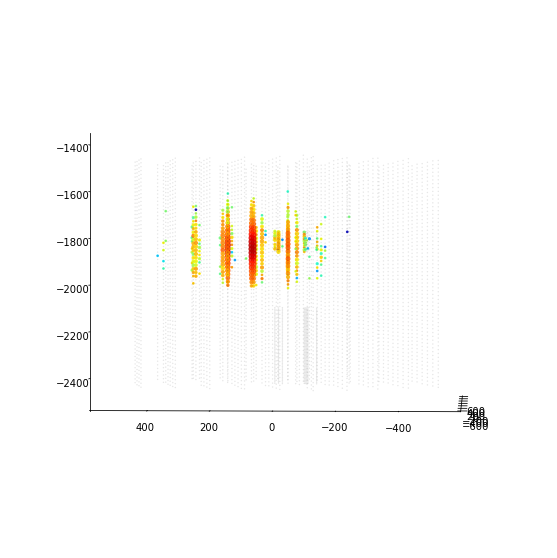

In [23]:
fig, ax = plot_event(event, det, save=False, channel="total", return_fig=True)

In [24]:
res = find_ratio(event)
print(res)
from scipy.spatial.transform import Rotation as R
theta = np.arccos(res.x[2])
phi = res.x[3]
psi = res.x[4]

     fun: 47.46449262380417
     jac: array([-0.00781881,  0.01424424,  0.01277698,  0.16944881,  0.16034392])
 message: 'Optimization terminated successfully.'
    nfev: 2667
     nit: 30
 success: True
       x: array([164.30642911, 245.6017677 ,   4.67603733,   3.18232589,
         3.25513944])


<ipython-input-24-4d3232fb5647>:4: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(res.x[2])


In [25]:
from ellipsoid import Ellipsoid

In [26]:
cfv, r, e = f(res.x, pts, return_objs=True)
thetas = np.random.rand(1200)*np.pi
phis = np.random.rand(1200)*2*np.pi
rs = e.r(thetas)
xs = rs*np.sin(thetas)*np.cos(phis)
ys = rs*np.sin(thetas)*np.sin(phis)
zs = rs*np.cos(thetas)
a = np.matmul(r.as_matrix(), np.array([xs, ys, zs])).transpose() + np.mean(pts, axis=1)



In [27]:
import matplotlib.pyplot as plt

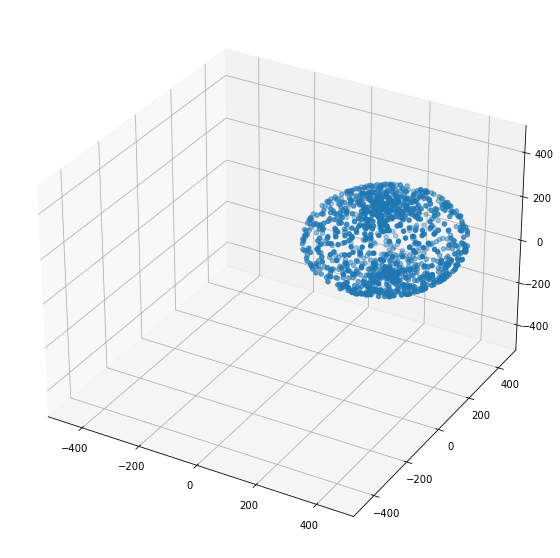

In [28]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.set_xlim3d(-500, 500)
ax.set_ylim3d(-500, 500)
ax.set_zlim3d(-500, 500)

ax.scatter3D(a[:, 0], a[:, 1], a[:, 2])
plt.show()

In [29]:
ax.scatter3D(xs,ys,zs,alpha=0.3)

330.76434569755827
190.3076579169949

In [46]:
def cost(pts, rotation, ellipsoid):
    pts = pts.transpose() - np.mean(pts, axis=1)
    pts = np.matmul(rotation.as_matrix(), pts.transpose())
    norms = np.linalg.norm(pts, axis=0)
    thetas = np.arccos(pts[2] / norms)
    rs = ellipsoid.r(thetas)
    print(norms)
    return np.mean(np.abs(np.unique(rs - norms)))

In [47]:
np.linalg.norm(pts, axis=0).shape

(141635,)

In [48]:
len(set(np.linalg.norm(pts, axis=0)))

154

In [60]:
as_ = np.linspace(0, 500, 100)
bs = np.linspace(0, 500, 100)
czs = np.linspace(-1, 1, 100)
phi = np.linspace(0, np.pi*2, 0)
ws = np.append(-1*np.logspace(3, -1), np.logspace(-1, 3))

array([-1.00000000e+03, -8.28642773e+02, -6.86648845e+02, -5.68986603e+02,
       -4.71486636e+02, -3.90693994e+02, -3.23745754e+02, -2.68269580e+02,
       -2.22299648e+02, -1.84206997e+02, -1.52641797e+02, -1.26485522e+02,
       -1.04811313e+02, -8.68511374e+01, -7.19685673e+01, -5.96362332e+01,
       -4.94171336e+01, -4.09491506e+01, -3.39322177e+01, -2.81176870e+01,
       -2.32995181e+01, -1.93069773e+01, -1.59985872e+01, -1.32571137e+01,
       -1.09854114e+01, -9.10298178e+00, -7.54312006e+00, -6.25055193e+00,
       -5.17947468e+00, -4.29193426e+00, -3.55648031e+00, -2.94705170e+00,
       -2.44205309e+00, -2.02358965e+00, -1.67683294e+00, -1.38949549e+00,
       -1.15139540e+00, -9.54095476e-01, -7.90604321e-01, -6.55128557e-01,
       -5.42867544e-01, -4.49843267e-01, -3.72759372e-01, -3.08884360e-01,
       -2.55954792e-01, -2.12095089e-01, -1.75751062e-01, -1.45634848e-01,
       -1.20679264e-01, -1.00000000e-01,  1.00000000e-01,  1.20679264e-01,
        1.45634848e-01,  